In [1]:
# initialize
import mne
import os
import scipy.io
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
from itertools import permutations,combinations
from IPython.display import clear_output
import seaborn as sns
from scipy.linalg import toeplitz
from numpy import linalg as LA
from mne.event import define_target_events

data_path = os.path.dirname(os.path.dirname(os.getcwd()))


save_path = data_path + '/python/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


save_path = data_path + '/python/data/extracted_features/features.pkl'
feat = pd.read_pickle(save_path)

clear_output()

In [17]:
# data preprocessing parameters
remove_first = 0.5 #second
new_sampling_rate = 100

no_surrogate = 1000
Features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']


con = ['hyper','normal','hypo','All']
con = 'All'

trial_len = 2 #(greater than)second 

apply_delay = False
delay = [0]

# filter frequency
apply_filter = True
filter_band = [1,4]



# cca parameters


# CCA functions
def nanRXY(X,Y):
    D = X.shape[0]
    x = np.vstack([X,Y])
    RXY = np.cov(x)
    
    Rxx = RXY[0:D,0:D]
    Ryy = RXY[D:,D:]
    Rxy = RXY[0:D,D:]
    Ryx = RXY[D:,0:D]
    return Rxx,Ryy,Rxy,Ryx
    
def regInv(R,K,typeF):
    
    eigenValues,eigenVectors = LA.eigh(R)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    if(typeF=='sqrt'):
        d = 1/np.sqrt(eigenValues[-K:])  # regularized sqrt inverse
    else:
        d = 1/eigenValues[-K:]           #regularized inverse

    d = np.diag(d)   
    SqrtInvR= np.dot(eigenVectors[:,-K:], (np.dot( d, eigenVectors[:,-K:].T)))

    return SqrtInvR

def myCannoncorr(X,Y,Kx,Ky):
    Rxx,Ryy,Rxy,Ryx = nanRXY(X,Y)    

    # compute A
    Rxxnsq = regInv(Rxx,Kx,'sqrt'); # regularized Rxx^(-1/2)
    Ryyn = regInv(Ryy,Ky,'x')

    M = Rxxnsq.dot(Rxy).dot(Ryyn).dot(Ryx).dot(Rxxnsq)
    M = np.sum([M,M.T],axis=0) / 2   # fix nummerical precision asymmetric

    eigenValues,eigenVectors = LA.eigh(M)
    idx = np.argsort(eigenValues)
    #idx = idx[::-1]

    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    d = eigenVectors[:,-np.min((Kx,Ky)):]    
    A = Rxxnsq.dot(d)    # invert coordinate transformation


    # compute B
    Ryynsq=regInv(Ryy,Ky,'sqrt') # regularized Ryy^(-1/2)
    D=Ryynsq.dot(Ryx).dot(Rxxnsq).dot(d)
    B=Ryynsq.dot(D)


    U=A.T.dot(X)
    V=B.T.dot(Y)
    
    
    nVars= np.min((U.shape[0],V.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(U[i,:],V[i,:])
        rhos[i] = r
        pvals[i] = p
    
    
    return A,B,rhos,pvals,U,V,Rxx,Ryy

def get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate):   
    b = B[:,0:nComp]/LA.norm(B[:,0:nComp])
    forwards = Ryy.dot(b).dot(LA.inv(b.T.dot(Ryy).dot(b)))  # B are the spatial filters applied to the EEG
    filters = A[:,0:nComp] # A are the filters applied to the kinematics    
    tvec=np.arange((-temporal_aperature/2+1),(temporal_aperature/2)+1)/new_sampling_rate
    
    return forwards,filters, tvec


#the temporal aperture -- how long to filter the kinematic signals (i.e., 1 second)
temporal_aperature = 100


Kx = 20    


sperate_tounge = True
seperate_jaw = False

if(sperate_tounge):
    Ky = 3
    nComp = 3
    features = ['TTCD','TMCD','TBCD']
    features = np.arange(len(Features))[np.in1d(Features, features)]
    sperate_name = '_tongue'
elif(seperate_jaw):
    Ky = 3
    nComp = 3
    features = ['jawaopening','lipaparature','lipProtrusion']
    features = np.arange(len(Features))[np.in1d(Features, features)]
    sperate_name = '_lipJaw'
else:
    Ky = 5
    nComp = 5
    features = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    features = np.arange(len(Features))[np.in1d(Features, features)]
    sperate_name = ''
    
    
    
################################ name ################################################
if(apply_filter):
    save_name = 'cca_yannis_Greaterthan_'+str(trial_len)+'sec_removeFirst_'\
            +str(remove_first)+'concatALLsub_'+str(delay[0])\
            +'delay_'+str(temporal_aperature)+'temporalAperature'\
            +'_filter_'+str(filter_band[0])+'-'+str(filter_band[1])\
            +'_kx-'+str(Kx)+'_ky-'+str(Ky)+sperate_name
else:
    save_name = 'cca_yannis_Greaterthan_'+str(trial_len)+'sec_removeFirst_'\
            +str(remove_first)+'concatALLsub_'+str(delay[0])\
            +'delay_'+str(temporal_aperature)+'temporalAperature_removeOnesub'\
            +'_kx-'+str(Kx)+'_ky-'+str(Ky)+sperate_name


In [18]:
save_name

'cca_yannis_Greaterthan_2sec_removeFirst_0.5concatALLsub_0delay_100temporalAperature_filter_1-4_kx-20_ky-3_tongue'

# data selection


In [19]:
# data selection functions
def get_eeg(raw,mat,resample_freq):
    trialno = mat['experiment']['media'][0,0]['permute'][0][0][0] 
    events_ = mne.find_events(raw, stim_channel='Trigger')
    a = events_[np.where(events_[:,2] == 105)[0],0]
    b = events_[np.where(events_[:,2] == 106)[0],0]

    a = a - raw.first_samp
    b = b - raw.first_samp

    A = raw.get_data()
    B=[]
    for i in range(0,len(a)):
        #c = signal.decimate(A[0:59,a[i]:b[i]], 10) # decimate to 200 hz 1000/100 =10
        c = A[0:59,a[i]:b[i]]
        x = c.shape[1]/1000 # Number of seconds in signal X
        x = x*resample_freq     # Number of samples to downsample
        c = scipy.signal.resample(c, int(np.ceil(x)),axis=1)
    
        df = pd.DataFrame({'trialno':trialno[i],'eeg':[c]})
        B.append(df)
    A = pd.concat((B),axis=0)
    clear_output()
    return A

def get_EMA(mat,feat):    
    trialno = mat['experiment']['media'][0,0]['permute'][0][0][0]    
    response = np.stack(mat['experiment']['media'][0,0]['Cresponse'][0][0].flatten()) - \
                np.stack(mat['experiment']['media'][0,0]['Sresponse'][0][0].flatten())    
    RT = np.stack(mat['experiment']['media'][0,0]['responseT'][0][0].flatten())   
    filename = np.stack(mat['experiment']['media'][0][0]['filename'][0][0][0]).flatten()
    df1 = pd.DataFrame({'trialno': range(200)})
    df1['trialno'] = trialno
    df1['response'] = response
    df1['RT'] = RT

    a = feat.merge(df1,on='trialno')
    
    return a

def align_data(B):
    eeg=[]
    ema=[]
    eeg_ema=[]
    for i in range(0,B.shape[0]):
        a = np.stack(B.iloc[i]['eeg']).shape[1]
        b = np.stack(B.iloc[i]['TTCD']).shape[0]
        
        x = np.stack((B.iloc[i]['envelop'].flatten(),
                       B.iloc[i]['jawaopening'].flatten(),
                       B.iloc[i]['lipaparature'].flatten(),
                       B.iloc[i]['lipProtrusion'].flatten(),
                       B.iloc[i]['TBCD'].flatten(),
                       B.iloc[i]['TMCD'].flatten(),
                       B.iloc[i]['TTCD'].flatten()))
        X=[]
        Y=[]
        if(b>a):
            X = B.iloc[i]['eeg']
            Y = x[:,:a]
        elif(a>b):
            X = B.iloc[i]['eeg'][:,:b]
            Y = x
        else:
            X = B.iloc[i]['eeg']
            Y = x
            
        eeg.append(X)
        ema.append(Y)    
        eeg_ema.append(np.vstack((X,Y)))
    return eeg,ema,eeg_ema

def do_filter(data,sfreq,filter_band):
    for i in range(0,len(data)):
        filt = mne.filter.filter_data(data[i],sfreq,filter_band[0], filter_band[1], 
                                      method = 'iir',n_jobs=1,
                           iir_params = dict(order=4, ftype='butter', output='sos'),
                                      verbose ='ERROR')
        data[i] = filt

    return data
        
def select_portion_applyDelay(data,remove_first,d,sfreq,apply_delay):
    
    rs = 0.5*sfreq
    dd = d*sfreq
    L = []
    trial_no = len(data)
    eeg=[]
    ema=[]
    for tr in range(0,trial_no):
        # remove first from the begining
        aa = data[tr][:,int((remove_first)*sfreq):]
        
        if(apply_delay):
            trial_len = aa.shape[1] - 1*sfreq

            start_i = round(dd)
            end_i = round(dd+trial_len)
            start_s = round(rs)
            end_s = round(rs+trial_len)

            E = aa[0:59,int(start_i):int(end_i)]
            S = aa[-7:,int(start_s):int(end_s)]
        else:
            E = aa[0:59,:]
            S = aa[-7:,:]
        
        eeg.append(E)
        ema.append(S)
        L.append(S.shape[1])
        
    return eeg,ema,np.asarray(L)

def prepare_CCA_dataformat(eeg,ema,temporal_aperature,L,features):
    
    aa = np.hstack(ema)
    aa = stats.zscore(aa, axis=1)
    aa = aa[features,:]
    
    mark_bad_trial = []
    X = []
    
    for t in range(0,len(ema)):
        a = aa[:,0:L[t]]
        #print(a.shape)
        tmp =[]
        for i in range(0,a.shape[0]):
            x = toeplitz(a[i,:])
            y= np.tril(np.ones((x.shape[0], x.shape[0]), dtype=int))
            x = x*y
            tmp.append(x[:,0:temporal_aperature])
        tmp = np.hstack(tmp)
        
        if(tmp.shape[1]==aa.shape[0]*temporal_aperature):
            tmp = np.hstack((tmp,np.ones((tmp.shape[0],1))))
            X.append(tmp) 
        else:
            mark_bad_trial.append(t)

        aa = aa[:,a.shape[1]:]

    ema = np.vstack(X)
    
    mark_bad_trial = np.asarray(mark_bad_trial)
    eeg_ = []
    for e in range(0,len(eeg)):
        if not(np.isin(e,mark_bad_trial)):        
            eeg_.append(eeg[e])

    eeg = np.hstack(eeg_)
    
    return eeg,ema.T,X,eeg_,mark_bad_trial

In [20]:
# (greater than) trial_len and concat all the subjects in one delay
EEG = []
EMA = []
frame=[]
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)

    a = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
    raw_fname = a +'/exp/data/matlab_exp_data/'+subject_name[s]+'.mat'
    mat = scipy.io.loadmat(raw_fname)
    trialno = mat['experiment']['media'][0,0]['permute'][0][0][0] 

    eeg = get_eeg(raw,mat,new_sampling_rate)
    ema = get_EMA(mat,feat)
    A = eeg.merge(ema,on='trialno')

    #take only the correct response
    A = A[A['response']==0]

    # select trial length
    B = A[A['Trial_len']>=trial_len]

    # align both data
    eeg,ema,eeg_ema = align_data(B)
    
    # apply filter 
    if(apply_filter):
        eeg_ema = do_filter(eeg_ema,new_sampling_rate,filter_band)
    
    #select portion with delay if any
    eeg,ema,L = select_portion_applyDelay(eeg_ema,remove_first,delay[0]+0.5,
                                          new_sampling_rate,apply_delay)
    
    #prepare for CCA
    eeg,ema,_,_,_, = prepare_CCA_dataformat(eeg,ema,temporal_aperature,L,features)
    
    EEG.append(eeg)
    EMA.append(ema)
    frame.append(eeg.shape[1])

EEG = np.hstack(EEG)    
EMA = np.hstack(EMA) 

In [21]:
# cca train 
A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)

X=[]
for s in range(0,len(subject_name)):
    if(s==0):
        u=U[:,0:frame[s]]
        v=V[:,0:frame[s]]
    else:
        u=U[:,frame[s-1]:frame[s-1]+frame[s]]
        v=V[:,frame[s-1]:frame[s-1]+frame[s]]

    nVars= np.min((u.shape[0],v.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(u[i,:],v[i,:])
        rhos[i] = r
        pvals[i] = p
        
    df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                   'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})
    
    X.append(df)
    print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/'+save_name+'.pkl'
data_CCA.to_pickle(save_path)

clear_output()




In [ ]:
# concat all the subjects in one delay (surrogate)

save_name = save_name + '_surrogate'

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

###########################
for surr in range(0,no_surrogate):
    frame = []
    EEG = []
    EMA = []
    for s in range(0,len(subject_name)):
        for d in delay:
            eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)    
            np.random.shuffle(eeg)
            np.random.shuffle(ema)
            eeg,ema = restructure_data(eeg,ema,temporal_aperature)
            EEG.append(eeg)
            EMA.append(ema)
            frame.append(eeg.shape[1])

    EEG = np.hstack(EEG)    
    EMA = np.hstack(EMA)     


    # cca train 
    A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)
    
    

    X=[]
    for s in range(0,len(subject_name)):
        if(s==0):
            u=U[:,0:frame[s]]
            v=V[:,0:frame[s]]
        else:
            u=U[:,frame[s-1]:frame[s-1]+frame[s]]
            v=V[:,frame[s-1]:frame[s-1]+frame[s]]

        nVars= np.min((u.shape[0],v.shape[0]))
        rhos = np.zeros((nVars,1))
        pvals = np.zeros((nVars,1))

        for i in range(0,nVars):
            r,p = stats.pearsonr(u[i,:],v[i,:])
            rhos[i] = r
            pvals[i] = p

        df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                       'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})

        X.append(df)
        print(subject_name[s]+'-'+str(surr))
    data_CCA = pd.concat((X),axis=0)
    save_path = data_path + '/python/data/cca/surrogate/'+save_name+str(surr)+'.pkl'
    data_CCA.to_pickle(save_path)
    clear_output()

# --------------------------------------------------------------------------

In [ ]:
# read epoches
Tmin = 0
Tmax = 3.51
trial_len = 2
remove_first = 0.5 #seconds

GA_epoches = []
for s in subject_name:
    save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin)+'-' \
    +str(Tmax)+'-trialLen-'+str(trial_len)+'_normalized.fif'
    a = mne.read_epochs(save_path)
    GA_epoches.append(a)
    
    # save matlab files for yannis matlab analysis
    #save_path = data_path + '/python/matlab_CCA/data/'+s+'.mat'
    #scipy.io.savemat(save_path, {'data':a.get_data(),'label':a.ch_names})

    print('----------------------------------------------------------------------------------------------------------------'+s)
clear_output()

In [ ]:
# resample the data to new_sampling_rate

for s in range(0,len(subject_name)):
    GA_epoches[s].resample(new_sampling_rate, npad='auto')


# 2sec

use same amount of data common to all trials (here 2sec) <br>


In [ ]:
# 2sec trial functions

def coherence_preprocess_delay(epochs,remove_first,d,trial_len,extra_channels,eeg_channles,condition):	

    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
        
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(extra_channels)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
        
    return E.get_data(),S.get_data()

def restructure_data(eeg,ema,temporal_aperature):
    eeg = np.hstack(eeg)

    x = np.hstack(ema)
    x = stats.zscore(x, axis=1)
    ema = np.stack(np.split(x, ema.shape[0], axis=1))

    X = []
    for t in range(0,ema.shape[0]):
        a = ema[t,:,:]
        tmp =[]
        for i in range(0,a.shape[0]):
            x = toeplitz(a[i,:])
            y= np.tril(np.ones((x.shape[0], x.shape[0]), dtype=int))
            x = x*y
            tmp.append(x[:,0:temporal_aperature])
        tmp = np.hstack(tmp)   
        X.append(tmp) 

    X = np.vstack(X)
    ema = np.hstack((X,np.ones((X.shape[0],1))))

    return eeg,ema.T


In [ ]:
# select data (2sec)

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']


###########################


frame = []
for s in range(0,len(subject_name)):
    for d in delay:
        eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)    
        eeg,ema = restructure_data(eeg,ema,temporal_aperature)
        
        # cca train 
        A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(ema,eeg,Kx,Ky)

        

    
        df = pd.DataFrame({'subject':subject_name[s],'Delay':d,'A':[A],'B':[B],'r':[rhos],
                           'p':[pvals],'U':[U],'V':[V],'Rxx':[Rxx],'Ryy':[Ryy]})
        frame.append(df)
        print(str(d)+'-'+subject_name[s])

    #df = pd.concat((frame),axis=0)
        
        
data_CCA = pd.concat((frame),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_2sec_envelop.pkl'
#save_path = data_path + '/python/data/cca/cca_yannis_2sec'+str(fmin)+'-'+str(fmax)+'.pkl'
data_CCA.to_pickle(save_path)

clear_output()

use same amount of data common to all trials (here 2sec) concat all the subjects in one delay

In [ ]:
# select data (2sec) concat all the subjects in one delay

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

###########################

frame = []
EEG = []
EMA = []
for s in range(0,len(subject_name)):
    for d in delay:
        eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)    
        eeg,ema = restructure_data(eeg,ema,temporal_aperature)
        EEG.append(eeg)
        EMA.append(ema)
        frame.append(eeg.shape[1])
        
EEG = np.hstack(EEG)    
EMA = np.hstack(EMA)     


# cca train 
A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)

X=[]
for s in range(0,len(subject_name)):
    if(s==0):
        u=U[:,0:frame[s]]
        v=V[:,0:frame[s]]
    else:
        u=U[:,frame[s-1]:frame[s-1]+frame[s]]
        v=V[:,frame[s-1]:frame[s-1]+frame[s]]

    nVars= np.min((u.shape[0],v.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(u[i,:],v[i,:])
        rhos[i] = r
        pvals[i] = p
        
    df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                   'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})
    
    X.append(df)
    print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/'+save_name+'.pkl'
data_CCA.to_pickle(save_path)
clear_output()

In [ ]:
# select data (2sec) concat all the subjects in one delay (surrogate)

save_name = save_name + '_surrogate'

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

###########################
for surr in range(0,no_surrogate):
    frame = []
    EEG = []
    EMA = []
    for s in range(0,len(subject_name)):
        for d in delay:
            eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)    
            np.random.shuffle(eeg)
            np.random.shuffle(ema)
            eeg,ema = restructure_data(eeg,ema,temporal_aperature)
            EEG.append(eeg)
            EMA.append(ema)
            frame.append(eeg.shape[1])

    EEG = np.hstack(EEG)    
    EMA = np.hstack(EMA)     


    # cca train 
    A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)
    
    

    X=[]
    for s in range(0,len(subject_name)):
        if(s==0):
            u=U[:,0:frame[s]]
            v=V[:,0:frame[s]]
        else:
            u=U[:,frame[s-1]:frame[s-1]+frame[s]]
            v=V[:,frame[s-1]:frame[s-1]+frame[s]]

        nVars= np.min((u.shape[0],v.shape[0]))
        rhos = np.zeros((nVars,1))
        pvals = np.zeros((nVars,1))

        for i in range(0,nVars):
            r,p = stats.pearsonr(u[i,:],v[i,:])
            rhos[i] = r
            pvals[i] = p

        df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                       'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})

        X.append(df)
        print(subject_name[s]+'-'+str(surr))
    data_CCA = pd.concat((X),axis=0)
    save_path = data_path + '/python/data/cca/surrogate/'+save_name+str(surr)+'.pkl'
    data_CCA.to_pickle(save_path)
    clear_output()

# whole trial

use all trial length (longer trial will have more contribution)


In [ ]:
# whole trial functions
def epoch(raw, mat,Tmin, Tmax):
    # ignore stimuli shorter than tmax ms
    events = mne.find_events(raw, stim_channel='Trigger')
    reference_id = 105  # speech onset
    target_id = 106  # speech offset
    sfreq = raw.info['sfreq']  # sampling rate
    tmin = 0  
    new_id = 99  # the new event id for a hit. If None, reference_id is used.
    fill_na = 105  # the fill value for misses
    events_, lag = define_target_events(events, reference_id, target_id,sfreq, tmin, Tmax, new_id, fill_na)
    events_  = np.where(events_[:,2] == 105)[0] +1


    #behaviour (remove the wrong answer trials and seperate the in three conditions)	
    condition= mat['behaviour']['condition'][0]
    response= mat['behaviour']['response'][0]
    a = np.hstack((condition[0],response[0]))

    df = pd.DataFrame({'condition':a[:,0],'response':a[:,1]})
    df.index = df.index + 1

    hyper  = df.loc[(df['condition'] == 1) & (df['response'] == 0)]
    normal = df.loc[(df['condition'] == 2) & (df['response'] == 0)]
    hypo   = df.loc[(df['condition'] == 3) & (df['response'] == 0)]

    events = mne.find_events(raw, stim_channel='trial_no')
    hyper = np.intersect1d(events_, hyper.index.values)
    normal = np.intersect1d(events_, normal.index.values)
    hypo = np.intersect1d(events_, hypo.index.values)

    a = np.concatenate((hyper,normal,hypo),axis=0)
    IDX = np.sort(a, axis=0) -1

    hyper = events[hyper-1]
    hyper[:,2] = 1
    normal = events[normal-1]
    normal[:,2] = 2
    hypo = events[hypo-1]
    hypo[:,2] = 3
    a = np.vstack((hyper,normal,hypo))
    events = np.sort(a, axis=0)
    
    ##########
    
    #add EMA, envelop signal as extra channels
    extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    envelop = mat['behaviour']['envelop'][0][0]
    jawaopening = mat['behaviour']['jawaopening'][0][0]
    lipaparature = mat['behaviour']['lipaparature'][0][0]
    lipProtrusion = mat['behaviour']['lipProtrusion'][0][0]
    TTCD = mat['behaviour']['TTCD'][0][0]
    TMCD = mat['behaviour']['TMCD'][0][0]
    TBCD = mat['behaviour']['TBCD'][0][0]
    phonemeRate = mat['behaviour']['phonemeRate'][0][0]
    phonemeDuration = mat['behaviour']['phonemeDuration'][0][0]

    A = []
    B = []
    for i in range(0,len(IDX)):
        a = np.vstack((envelop[IDX[i]][0],jawaopening[IDX[i]][0].T,lipaparature[IDX[i]][0].T,lipProtrusion[IDX[i]][0].T,
                       TTCD[IDX[i]][0].T,TMCD[IDX[i]][0].T,TBCD[IDX[i]][0].T))
        A.append(a)
        a = np.hstack((phonemeRate[IDX[i]][0][0][0],phonemeDuration[IDX[i]][0][0][0]))
        B.append(a)
        
    return events,A,np.stack(B)

def restructure_data(raw,events,EMA):
    events_ = mne.find_events(raw, stim_channel='Trigger')
    a = events_[np.where(events_[:,2] == 105)[0],0]
    b = events_[np.where(events_[:,2] == 106)[0],0]

    c = np.in1d(a,events[:,0])
    a = a[c] - raw.first_samp
    b = b[c] - raw.first_samp

    A = raw.get_data()
    B=[]
    for i in range(0,len(a)):
        c = signal.decimate(A[0:59,a[i]:b[i]], 10) # decimate to 200 hz 1000/100 =10
        d = signal.decimate(EMA[i], 4) # decimate to 200 hz 400/100 = 4

        #c = A[0:59,a[i]:b[i]]
        #d = EMA[i]
        if(c.shape[1]>d.shape[1]):
            x = np.pad(d,((0,0),(0,c.shape[1]-d.shape[1])), 'constant')
            x = np.vstack((c,x))
        elif(c.shape[1]<d.shape[1]):
            x = np.pad(c,((0,0),(0,d.shape[1]-c.shape[1])), 'constant')
            x = np.vstack((x,d))
        else:
            x = np.vstack((c,d))
        B.append(x)
    clear_output()
    
    x = np.column_stack(B)
    eeg = x[0:59,:]
    ema = x[60:66,:]
    return B

def restructure_data2(eeg,ema,temporal_aperature,L,features):
    
    aa = np.hstack(ema)
    aa = stats.zscore(aa, axis=1)
    if(features=='envelop'):
        aa = aa[0,:]
    else:
        aa = aa[1:,:]
    mark_bad_trial = []
    X = []
    
    for t in range(0,len(ema)):
        a = aa[:,0:L[t]]
        #print(a.shape)
        tmp =[]
        for i in range(0,a.shape[0]):
            x = toeplitz(a[i,:])
            y= np.tril(np.ones((x.shape[0], x.shape[0]), dtype=int))
            x = x*y
            tmp.append(x[:,0:temporal_aperature])
        tmp = np.hstack(tmp)

        if(tmp.shape[1]==600):
            tmp = np.hstack((tmp,np.ones((tmp.shape[0],1))))
            X.append(tmp) 
        else:
            mark_bad_trial.append(t)

        aa = aa[:,a.shape[1]:]

    ema = np.vstack(X)
    
    mark_bad_trial = np.asarray(mark_bad_trial)
    eeg_ = []
    for e in range(0,len(eeg)):
        if not(np.isin(e,mark_bad_trial)):        
            eeg_.append(eeg[e])

    eeg = np.hstack(eeg_)
    
    return eeg,ema.T,X,eeg_,mark_bad_trial

def get_data(data,remove_first,d,sfreq,one_delay):
    
    rs = 0.5*sfreq
    dd = d*sfreq
    L = []
    trial_no = len(data)
    eeg=[]
    ema=[]
    for tr in range(0,trial_no):

        # remove first from the begining
        aa = data[tr][:,int((remove_first)*sfreq):]
        
        if(one_delay==0):
            trial_len = aa.shape[1] - 1*sfreq

            start_i = round(dd)
            end_i = round(dd+trial_len)
            start_s = round(rs)
            end_s = round(rs+trial_len)

            E = aa[0:59,int(start_i):int(end_i)]
            S = aa[-7:,int(start_s):int(end_s)]
        elif(one_delay==1):
            E = aa[0:59,:]
            S = aa[-7:,:]
        
        eeg.append(E)
        ema.append(S)
        L.append(S.shape[1])
        
    return eeg,ema,np.asarray(L)


In [ ]:
# whole trial

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop']
d = 0

###########################

frame = []
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,EMA,phoneme_rate_dur = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,EMA)
    
    for d in delay:
        
        eeg,ema,L = get_data(A_sub,remove_first,d+0.5,new_sampling_rate,0)
        eeg,ema = restructure_data2(eeg,ema,temporal_aperature,L,features)
        
        # cca train 
        A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(ema,eeg,Kx,Ky)

        df = pd.DataFrame({'subject':subject_name[s],'Delay':d,'A':[A],'B':[B],'r':[rhos],
                           'p':[pvals],'U':[U],'V':[V],'Rxx':[Rxx],'Ryy':[Ryy]})
        frame.append(df)
        print(str(d)+'-'+subject_name[s])

    #df = pd.concat((frame),axis=0)
        
        
data_CCA = pd.concat((frame),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_alltrial_envelop.pkl'
#save_path = data_path + '/python/data/cca/cca_yannis_2sec'+str(fmin)+'-'+str(fmax)+'.pkl'
data_CCA.to_pickle(save_path)
clear_output()

use all trials concat all the subjects in one delay

In [ ]:
# whole trial concat all the subjects in one delay
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop']

frame = []
EEG = []
EMA = []
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,a = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,a)
    eeg,ema,L = get_data(A_sub,remove_first,d+0.5,sfreq)
    eeg,ema = restructure_data2(eeg,ema,temporal_aperature,L,features)
    EEG.append(eeg)
    EMA.append(ema)
    frame.append(eeg.shape[1])
        
EEG = np.hstack(EEG)    
EMA = np.hstack(EMA)     


# cca train 
A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA,EEG,Kx,Ky)

X=[]
for s in range(0,len(subject_name)):
    if(s==0):
        u=U[:,0:frame[s]]
        v=V[:,0:frame[s]]
    else:
        u=U[:,frame[s-1]:frame[s-1]+frame[s]]
        v=V[:,frame[s-1]:frame[s-1]+frame[s]]

    nVars= np.min((u.shape[0],v.shape[0]))
    rhos = np.zeros((nVars,1))
    pvals = np.zeros((nVars,1))

    for i in range(0,nVars):
        r,p = stats.pearsonr(u[i,:],v[i,:])
        rhos[i] = r
        pvals[i] = p
        
    df = pd.DataFrame({'subject':subject_name[s],'Delay':delay,'A':[A],'B':[B],'r':[rhos],
                   'p':[pvals],'U':[u],'V':[v],'Rxx':[Rxx],'Ryy':[Ryy]})
    
    X.append(df)
    print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_wholetrial_envelop_concatALLsub_0delay.pkl'
data_CCA.to_pickle(save_path)

clear_output()

# single trial cca

In [ ]:
# single trial in one delay using all trial

features = ['envelop']
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
d = 0

###
X=[]
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,a,phoneme_rate_dur = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,a)
    eeg,ema,L = get_data(A_sub,remove_first,d+0.5,new_sampling_rate,1)
    A,B,EMA,EEG,a = restructure_data2(eeg,ema,temporal_aperature,L,features)
    phoneme_rate_dur = np.delete(phoneme_rate_dur, a,axis=0)
    events = np.delete(events, a,axis=0)

    for i in range(0,len(eeg)):        
        # cca train 
        A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(EMA[i].T,EEG[i],Kx,Ky)
        
        forwards,filters, tvec = get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate)
        filters = filters[0:-1,:]
        filters = np.dstack(np.array_split(filters,filters.shape[0]/temporal_aperature,axis=0))
        
        frame=[]
        a = pd.Series({'Trial':i,'subject':subject_name[s],'Delay':d,
                       'phoneme_rate':phoneme_rate_dur[i,0],'phoneme_dur':phoneme_rate_dur[i,1],
                      'condition':events[i,2]})   
        frame.append(a)
        comp_idx = nComp-1
        for i in range(0,nComp):
            a = pd.Series({'Component'+str(comp_idx)+'_corr':rhos[i][0],
                           'Component'+str(comp_idx)+'_p':pvals[i][0],
                           'Component'+str(comp_idx)+'_topo':forwards[:,i],
                          'Component'+str(comp_idx)+'_filters':[filters[:,i,:]]})
            frame.append(a)
            comp_idx = comp_idx-1
        df = pd.concat((frame),axis=0)
        df = pd.DataFrame(df) 
        X.append(df.T)
        print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_singletrial_alltrial_0delay.pkl'
data_CCA.to_pickle(save_path)

clear_output()

# condition separated CCA

In [ ]:
# condition separated trial in one delay using all trial

features = ['envelop']
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
d = 0

###
X=[]
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,a,phoneme_rate_dur = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,a)
    eeg,ema,L = get_data(A_sub,remove_first,d+0.5,new_sampling_rate,1)
    A,B,EMA,EEG,a = restructure_data2(eeg,ema,temporal_aperature,L,features)
    phoneme_rate_dur = np.delete(phoneme_rate_dur, a,axis=0)
    events = np.delete(events, a,axis=0)

    for cc in range(1,4): 
        a = np.where(events[:,2]==cc)[0]
    
        A = []
        B = []
        for e in range(0,len(a)):
            A.append(EEG[a[e]])
            B.append(EMA[a[e]])

        eeg = np.hstack(A)
        ema = np.vstack(B)

        # cca train 
        A,B,rhos,pvals,U,V,Rxx,Ryy = myCannoncorr(ema.T,eeg,Kx,Ky)
        
        forwards,filters, tvec = get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate)
        filters = filters[0:-1,:]
        filters = np.dstack(np.array_split(filters,filters.shape[0]/temporal_aperature,axis=0))
        
        frame=[]
        a = pd.Series({'subject':subject_name[s],'Delay':d,'condition':cc})   
        frame.append(a)
        comp_idx = nComp-1
        for i in range(0,nComp):
            a = pd.Series({'Component'+str(comp_idx)+'_corr':rhos[i][0],
                           'Component'+str(comp_idx)+'_p':pvals[i][0],
                           'Component'+str(comp_idx)+'_topo':forwards[:,i],
                          'Component'+str(comp_idx)+'_filters':[filters[:,i,:]]})
            frame.append(a)
            comp_idx = comp_idx-1
        df = pd.concat((frame),axis=0)
        df = pd.DataFrame(df) 
        X.append(df.T)
        print(subject_name[s])

data_CCA = pd.concat((X),axis=0)
save_path = data_path + '/python/data/cca/cca_yannis_bycondition_alltrial_0delay.pkl'
data_CCA.to_pickle(save_path)

clear_output()

# ------------------------------------------------------------------------------

# CCA Analysis

# choosing CCA regularization parameters Kx and Ky (skip this section if already choosen)

different values of them affect the results.They should not affect the extracted components very much but they usually affect the correlation values. One good way for selecting values for these parameters is to to svd to your input matrices EEG and KIN and plot the variance accounted for curve as a function of the number of eigenvalues. You then look for a "knee" or saturation point in the curve and choose as many svd dimensions (Kx and Ky).


In [ ]:
# choosing the kx by svd [eeg]
u,s,vh=LA.svd(eeg)

#s = np.sort(s)
# plot the eigen values and choose the knee saturation point
plt.plot(s)

# its 5 here

In [ ]:
# choosing the ky by svd [ema]
u1,s1,vh1=LA.svd(ema)
plt.plot(s1)


# load data

In [22]:
# load data 
###########################
trial_len = 2 #(greater than)second 
delay = [0]
temporal_aperature = 100
remove_first = 0.5 #second
Kx = 20    

if(sperate_tounge):
    Ky = 3
    nComp = 3
    features = ['TTCD','TMCD','TBCD']
    sperate_name = '_tongue'
elif(seperate_jaw):
    Ky = 3
    nComp = 3
    features = ['jawaopening','lipaparature','lipProtrusion']
    sperate_name = '_lipJaw'
else:
    Ky = 5
    nComp = 5
    features = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    sperate_name = ''
    
################################ name ################################################
if(apply_filter):
    save_name = data_path + '/python/data/cca/'\
            +'cca_yannis_Greaterthan_'+str(trial_len)+'sec_removeFirst_'\
            +str(remove_first)+'concatALLsub_'+str(delay[0])\
            +'delay_'+str(temporal_aperature)+'temporalAperature'\
            +'_filter_'+str(filter_band[0])+'-'+str(filter_band[1])\
            +'_kx-'+str(Kx)+'_ky-'+str(Ky)+sperate_name+'.pkl'
    
    plot_name = 'TrLen>'+str(trial_len)+'s_delay='+str(delay[0])\
                +'s_TmpAptr='+str(temporal_aperature)\
                +'_filter_'+str(filter_band[0])+'-'+str(filter_band[1])\
                +'_kx-'+str(Kx)+'_ky-'+str(Ky)
else:
    save_name = data_path + '/python/data/cca/'\
            +'cca_yannis_Greaterthan_'+str(trial_len)+'sec_removeFirst_'\
            +str(remove_first)+'concatALLsub_'+str(delay[0])\
            +'delay_'+str(temporal_aperature)+'temporalAperature_removeOnesub'\
            +'_kx-'+str(Kx)+'_ky-'+str(Ky)+sperate_name+'.pkl'

    plot_name = 'TrLen>'+str(trial_len)+'s_delay='+str(delay[0])\
                +'s_TmpAptr='+str(temporal_aperature)+'_kx-'+str(Kx)+'_ky-'+str(Ky)

data_CCA = pd.read_pickle(save_name)


In [23]:
# arrange data
def get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate):   
    b = B[:,0:nComp]/LA.norm(B[:,0:nComp])
    forwards = Ryy.dot(b).dot(LA.inv(b.T.dot(Ryy).dot(b)))  # B are the spatial filters applied to the EEG
    filters = A[:,0:nComp] # A are the filters applied to the kinematics    
    tvec=np.arange((-temporal_aperature/2+1),(temporal_aperature/2)+1)/new_sampling_rate
    
    return forwards,filters, tvec

C = []

for s in range(0,len(subject_name)):
    for d in delay:
        df = data_CCA[(data_CCA['subject']==subject_name[s]) & (data_CCA['Delay']==d)]
        A = df['A'].get_values()[0]
        B = df['B'].get_values()[0]
        Ryy = df['Ryy'].get_values()[0]
        r = df['r'].get_values()[0]
        p = df['p'].get_values()[0]
        forwards,filters, tvec = get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate)
        filters = filters[0:-1,:]
        filters = np.dstack(np.array_split(filters,filters.shape[0]/temporal_aperature,axis=0))

        frame=[]
        a = pd.Series({'subject':subject_name[s],'Delay':d})   
        frame.append(a)
        comp_idx = nComp-1
        for i in range(0,nComp):
            a = pd.Series({'Component'+str(comp_idx)+'_corr':r[i][0],
                           'Component'+str(comp_idx)+'_p':p[i][0],
                           'Component'+str(comp_idx)+'_topo':forwards[:,i],
                          'Component'+str(comp_idx)+'_filters':[filters[:,i,:]]})
            frame.append(a)
            comp_idx = comp_idx-1
        df = pd.concat((frame),axis=0)
        df = pd.DataFrame(df) 
        C.append(df.T)
        
data_plot = pd.concat((C),axis=0)

data_plot.head()

,subject,Delay,Component2_corr,Component2_p,Component2_topo,Component2_filters,Component1_corr,Component1_p,Component1_topo,Component1_filters,Component0_corr,Component0_p,Component0_topo,Component0_filters
0,Alice,0,-0.003506,0.334418,"[-0.03483915571099725, -0.29438451798280607, 0...","[[[0.06690221839424104, 0.011064136705022671, ...",0.0240301,3.67137e-11,"[0.22574792107428343, 0.2616502657980026, 0.19...","[[[0.02967234873382744, 0.07701830218924959, -...",0.0484496,1.23889e-40,"[0.3234094838068669, 0.2912810636374623, 0.260...","[[[-0.05463402490631128, -0.04223896120111145,..."
0,Andrea,0,0.0118503,0.00133264,"[-0.03483915571099725, -0.29438451798280607, 0...","[[[0.06690221839424104, 0.011064136705022671, ...",-0.00762382,0.0389835,"[0.22574792107428343, 0.2616502657980026, 0.19...","[[[0.02967234873382744, 0.07701830218924959, -...",0.0502005,3.91937e-42,"[0.3234094838068669, 0.2912810636374623, 0.260...","[[[-0.05463402490631128, -0.04223896120111145,..."
0,Daniel,0,0.010317,0.00503623,"[-0.03483915571099725, -0.29438451798280607, 0...","[[[0.06690221839424104, 0.011064136705022671, ...",0.000286646,0.937889,"[0.22574792107428343, 0.2616502657980026, 0.19...","[[[0.02967234873382744, 0.07701830218924959, -...",0.0479313,7.50207e-39,"[0.3234094838068669, 0.2912810636374623, 0.260...","[[[-0.05463402490631128, -0.04223896120111145,..."
0,Elena,0,0.00970443,0.00836873,"[-0.03483915571099725, -0.29438451798280607, 0...","[[[0.06690221839424104, 0.011064136705022671, ...",-0.00129198,0.725558,"[0.22574792107428343, 0.2616502657980026, 0.19...","[[[0.02967234873382744, 0.07701830218924959, -...",0.0474367,4.73231e-38,"[0.3234094838068669, 0.2912810636374623, 0.260...","[[[-0.05463402490631128, -0.04223896120111145,..."
0,Elenora,0,0.00969921,0.00799866,"[-0.03483915571099725, -0.29438451798280607, 0...","[[[0.06690221839424104, 0.011064136705022671, ...",-0.00530395,0.146982,"[0.22574792107428343, 0.2616502657980026, 0.19...","[[[0.02967234873382744, 0.07701830218924959, -...",0.0464845,4.74688e-37,"[0.3234094838068669, 0.2912810636374623, 0.260...","[[[-0.05463402490631128, -0.04223896120111145,..."


In [24]:
# data investigate functions

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    if 'mask' in data:
        mask = data['mask'].any()
        mne.viz.plot_topomap(x, info.info, show=False,mask = mask,cmap='RdBu_r',
                             mask_params = dict(marker='o', markerfacecolor='k',
                                                markeredgecolor='k',linewidth=0, markersize=5))
    else:
        #mne.viz.plot_topomap(x, info.info, show=False,vmin=Vmin,vmax=Vmax,cmap='RdBu_r')
        mne.viz.plot_topomap(x, info.info, show=False,cmap='RdBu_r')
        
def plot_topo_image(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='weight amplitude')

# plot all components topo at one delay
def plotCCA_topo(data_plot,s,d):
    B = data_plot[data_plot['subject']==subject_name[s]]

    df = B[(B['Delay']==d)]

    frame = []
    for i in range(0,nComp):
        a = np.stack(df['Component'+str(i)+'_topo'].get_values()).mean(axis=0)
        a = pd.DataFrame({'Component':i,'Data':[a],'subject':s})
        frame.append(a)

    A = pd.concat((frame),axis=0)

    Vmin = np.stack(A['Data'].get_values()).min()
    Vmax = np.stack(A['Data'].get_values()).max()
    
    return A,Vmin,Vmax
        
# plot component filter
def plotComp_filter(data_plot,s,d,tvec):
    B = data_plot[data_plot['subject']==subject_name[s]]

    df = B[(B['Delay']==d)]
    
    A = []
    for i in range(0,nComp):
        a = df['Component'+str(i)+'_filters'].get_values()[0][0]
        A.append(a)    
    A = np.stack(A)
    
    if(abs(A.min())<abs(A.max())):
        aa = abs(A.max())
    else:
        aa = abs(A.min())
            
    f, ax = plt.subplots(figsize=(15,2))
    for i in range(0,nComp):
        a = A[i,:,:]
        axx=plt.subplot(1,nComp,i+1)
        plt.plot(tvec,a)
        plt.title('comp= '+str(i))
        plt.ylim([-aa,aa])
        #axx.set_xticklabels([0.1,tvec[0],0,tvec[-1]])
        if not(i==0):
            plt.yticks([])        
    
    plt.legend(features,loc='upper center', bbox_to_anchor=(-1, 1.5),ncol=6)
    
# plot 1 componet in all dealy avg subjects
def plotComp_delay(data_plot,comp):
    df = data_plot[['Delay','subject','Component'+str(comp)+'_corr']]

    #sns.lineplot(data=df,x='Delay',y='Component'+str(comp)+'_corr')
    sns.tsplot(data=df,time='Delay',value='Component'+str(comp)+'_corr',unit='subject')    
        
# plot all components at delay
def plotAllComp(data_plot,D):
    frame = []
    for i in range(0,nComp):
        A = data_plot[['Delay','subject','Component'+str(i)+'_corr']]
        A=A.rename(columns={'Component'+str(i)+'_corr':'Data'})
        A['component']=i
        frame.append(A)

    df = pd.concat((frame),axis=0)

    A = df[(df['Delay']==D)]


    f, ax = plt.subplots(figsize=(12,8))


    a=sns.tsplot(A,time="component", condition="subject",value='Data')
    plt.xlabel('Canonical component')
    plt.ylabel('Canonical correlation')
    ax.set_xlim(-0.5,6)
    return A

In [25]:
# select a delay and a subject
D=0
S=21

C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'TrLen>2s_delay=0s_TmpAptr=100_filter_1-4_kx-20_ky-3')

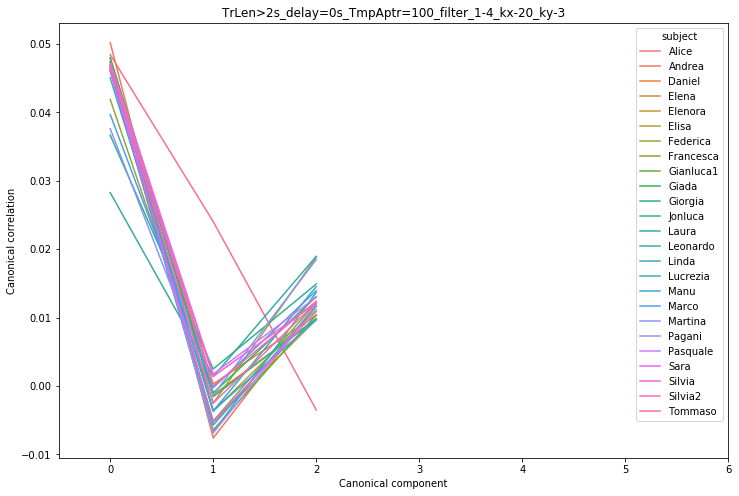

In [26]:
# plot all components and all subjects correlation score at delay
a = plotAllComp(data_plot,D)
plt.title(plot_name)


Text(0.5, 0.98, 'TrLen>2s_delay=0s_TmpAptr=100_filter_1-4_kx-20_ky-3')

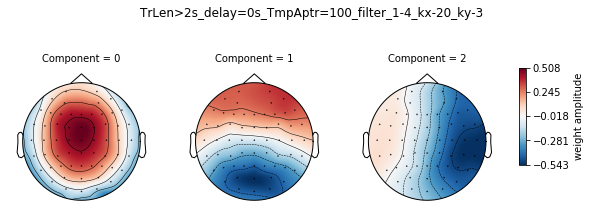

In [27]:
# plot all components topo at one delay
A,Vmin,Vmax=plotCCA_topo(data_plot,S,D)
plot_topo_image(A,Vmin,Vmax,'Component') 
plt.suptitle(plot_name)

Text(0.5, 1.3, 'TrLen>2s_delay=0s_TmpAptr=100_filter_1-4_kx-20_ky-3')

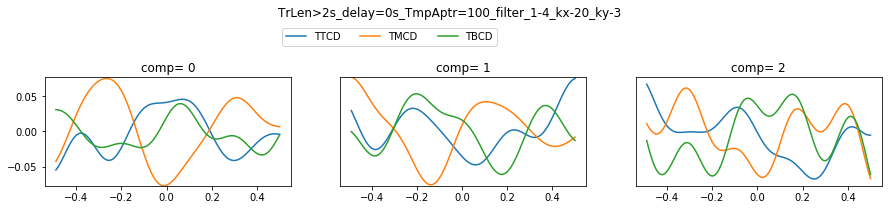

In [28]:
# plot component filter
plotComp_filter(data_plot,S,D,tvec)
plt.suptitle(plot_name,va='baseline',y=1.3)

In [ ]:
# all dealy plot topo
delay = np.arange(-5,5.5,0.5) / 10
# plot all components topo at one delay
for d in delay:
    A,Vmin,Vmax=plotCCA_topo(data_plot,S,d)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
# all delay plot filter
delay = np.arange(-5,5.5,0.5) / 10
delay = np.arange(-5,6) / 10

# plot component filter
for d in delay:
    plotComp_filter(data_plot,S,d)
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
# plot all subjects topo at one delay
for s in range(0,len(subject_name)):
    A,Vmin,Vmax=plotCCA_topo(data_plot,s,D)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[s])

In [ ]:
# plot all subjects topo at one delay
frame=[]
for s in range(0,len(subject_name)):
    A,Vmin,Vmax=plotCCA_topo(data_plot,s,D)
    frame.append(A)
    
A=pd.concat((frame),axis=0)
fg = sns.FacetGrid(A,col='Component',row='subject',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')

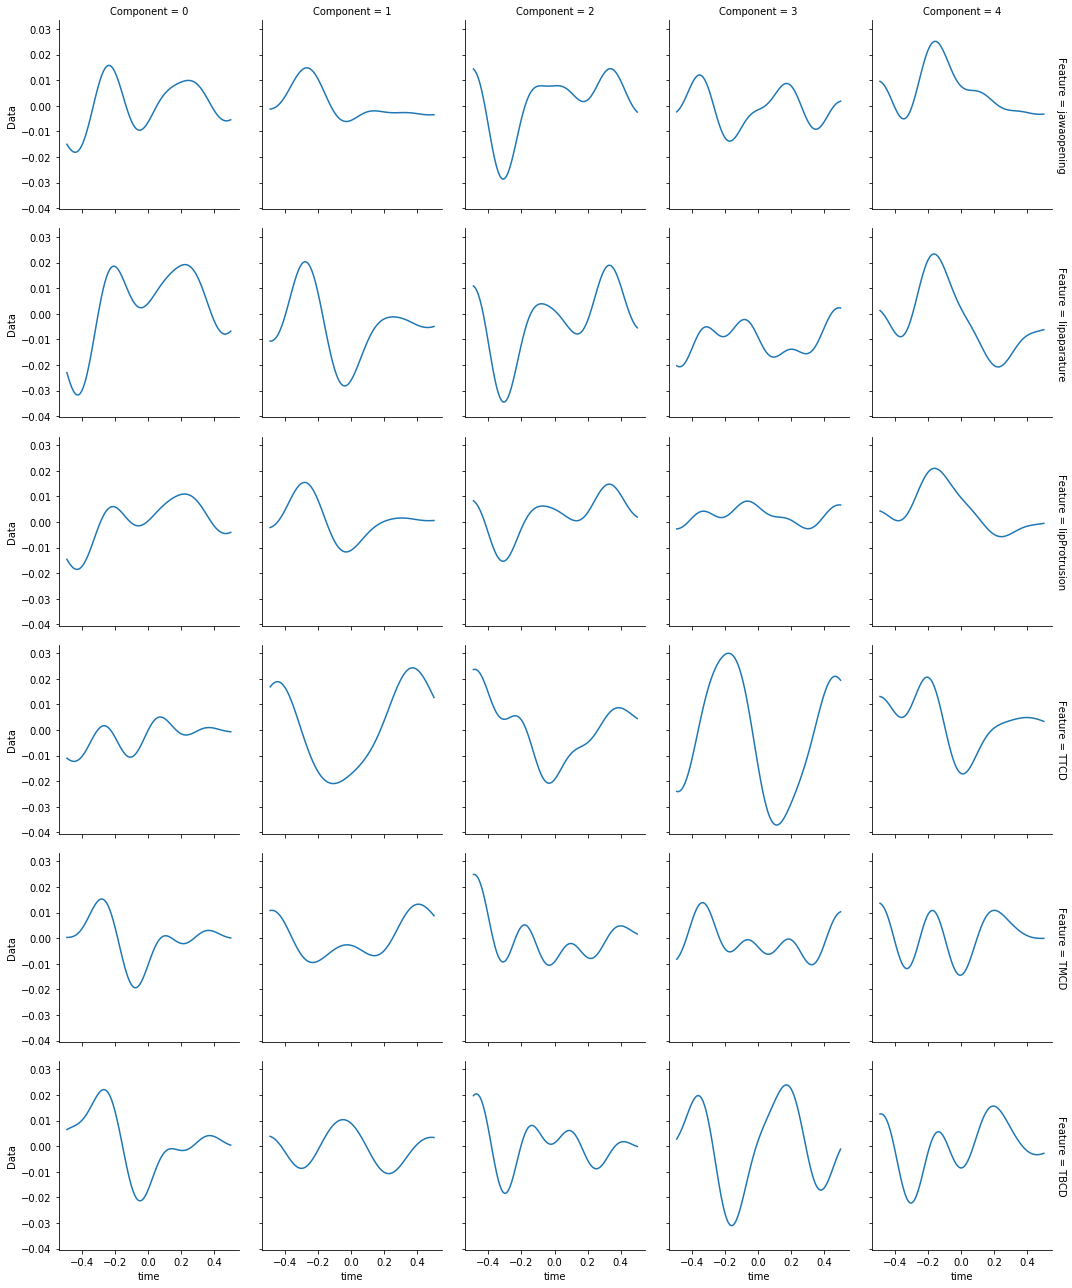

In [47]:
# explore temporal filters sperately
b = data_plot[(data_plot['subject']==subject_name[S]) & (data_plot['Delay']==D)]
A = []
for i in range(0,nComp):
    a = b['Component'+str(i)+'_filters'].get_values()[0][0]
    for f in range(0,len(features)):
        for j in range(0,a.shape[0]):
            df = pd.DataFrame({'Feature':features[f],'Component':i,'time':[tvec[j]],
                               'Data':a[:,f][j]})
            A.append(df)    
temporal_filters = pd.concat((A),axis=0)

fg = sns.FacetGrid(temporal_filters,col='Component',row='Feature',margin_titles=True)
b = fg.map_dataframe(sns.lineplot, 'time','Data')

In [ ]:
# plot 1 componet in all dealy avg subjects
comp = 0
plotComp_delay(data_plot,comp)

# statistics

#You can do statistics with the correlation values. One way to assess significance of these correlations is via a permutation test. You can shuffle the trials so as to break the correspondence between kinematics and EEG (the kinematics of trial 1 would be matched to the EEG of another trial - not trial 1). Do this permutation as many times as you can (e.g. 100 or 1000 times) and compute correlation values each time. Then by taking the 95 percentile of the distribution of rho values, you can assess significance of the actual rho values you already got.

In [ ]:
# get surrogate rhos and filters
save_name = 'cca_yannis_2sec_envelop_concatALLsub_0delay_surrogate'
save_name = 'cca_yannis_2sec_concatALLsub_0delay_surrogate'

surr_r = []
surr_filters = []
surr_topo = []

for surr in range(0,no_surrogate):
    save_path = data_path + '/python/data/cca/surrogate/'+save_name+str(surr)+'.pkl'
    data_CCA = pd.read_pickle(save_path)
    
    R = []
    for s in range(0,len(subject_name)):
        for d in delay:
            df = data_CCA[(data_CCA['subject']==subject_name[s]) & (data_CCA['Delay']==d)]
            r = df['r'].get_values()[0].flatten()
            R.append(r)            
    
    # no varition accros subject as all subjects were concatenated
    A = data_CCA['A'].get_values()[0]
    B = data_CCA['B'].get_values()[0]
    Ryy = data_CCA['Ryy'].get_values()[0]
    forwards,filters, tvec = get_component_topo_time(A,B,Ryy,temporal_aperature,nComp,new_sampling_rate)
    filters = filters[0:-1,:]
    filters = np.dstack(np.array_split(filters,filters.shape[0]/temporal_aperature,axis=0))
            
    R = np.stack(R) 
    surr_r.append(R)
    surr_filters.append(filters)
    surr_topo.append(forwards)
    
surr_r = np.dstack(surr_r)
surr_filters = np.stack(surr_filters)
surr_topo = np.stack(surr_topo)

In [ ]:
# significant rhos subject with components
A = []
for i in range(0,nComp):
    a = data_plot['Component'+str(i)+'_corr'].get_values()    
    A.append(a)

A = np.stack(A).T

a = np.percentile(surr_r,95,axis=2)

sub,comp=np.where(A>=a)
a = np.vstack((sub,comp))
print('significant subjects and comps')
print(a.T)




In [ ]:
# significant topo

# significant subject with components
th = np.percentile(surr_topo,95,axis=0)

frame = []
for i in range(0,nComp):
    a = data_plot['Component'+str(i)+'_topo'].get_values().mean() 
    mask = a >= th[:,i]
    frame.append(pd.DataFrame({'Component':i,'Data':[a],'mask':[mask]}))
    
A = pd.concat((frame),axis=0)

Vmin = np.stack(A['Data'].get_values()).min()
Vmax = np.stack(A['Data'].get_values()).max()


plot_topo_image(A,Vmin,Vmax,'Component') 


In [ ]:
# explore temporal filters sperately
b = data_plot[(data_plot['subject']==subject_name[S]) & (data_plot['Delay']==D)]
A = []
for i in range(nComp):
    a = b['Component'+str(i)+'_filters'].get_values()[0][0]
    for f in range(0,len(features)):
        for j in range(0,surr_filters.shape[1]):
            df = pd.DataFrame({'Feature':features[f],'Component':i,'time':[tvec[j]],
                               'cond':'surrogate','Data':[surr_filters[:,j,i,f].mean()]})
            A.append(df)    
            df = pd.DataFrame({'Feature':features[f],'Component':i,'time':[tvec[j]],
                               'cond':'original','Data':a[:,f][j]})
            A.append(df)    
            
            # significant times
            th = np.percentile(surr_filters[:,j,i,f],95)
            if(a[:,f][j]>=th):
                df = pd.DataFrame({'Feature':features[f],'Component':i,'time':[tvec[j]],
                               'cond':'significant','Data':0.02})
                
            else:
                df = pd.DataFrame({'Feature':features[f],'Component':i,'time':[tvec[j]],
                               'cond':'significant','Data': 0})    
            A.append(df)    
            
temporal_filters = pd.concat((A),axis=0)
fg = sns.FacetGrid(temporal_filters,col='Component',row='Feature',hue='cond',margin_titles=True)
b = fg.map_dataframe(sns.lineplot, 'time','Data').add_legend()

# single trial / condition wise CCA analysis

In [ ]:
#load data
save_path = data_path + '/python/data/cca/cca_yannis_bycondition_alltrial_0delay.pkl'
save_path = data_path + '/python/data/cca/cca_yannis_singletrial_alltrial_0delay.pkl'

data_CCA = pd.read_pickle(save_path)

In [ ]:
data_CCA.shape

In [ ]:
# arrange data (single trial)
frame=[]
for i in range(0,data_CCA.shape[0]):
    A = data_CCA.iloc[i]       
    for ii in range(0,nComp):
        a = pd.DataFrame({'subject':A['subject'],'Trial':[A['Trial']],
                       'phoneme_dur':A['phoneme_dur'],'phoneme_rate':A['phoneme_rate'],
                          'Component':ii,'corr':A['Component'+str(ii)+'_corr']})
        frame.append(a)
A = pd.concat((frame),axis=0)
A.head()


# apply some math on data
#a  = A['corr'].apply(lambda x: np.log(x))
#A['log_corr'] = pd.Series(a, index=A.index)

In [ ]:
# arrange data (by condition)
a = data_CCA[['Component0_corr','Component1_corr','Component2_corr','Component3_corr'
            ,'Component4_corr']].get_values().flatten()
b=[]
for i in range(0,nComp):
    b.append(np.ones(a.shape[0])+i)
b = np.stack(b).ravel()

A = pd.DataFrame()

A['Component'] = pd.Series(np.repeat(np.arange(0,nComp), len(subject_name)))
A['corr'] = pd.Series(a,dtype='float')
A['phoneme_dur'] = pd.Series(data_CCA['phoneme_dur'].get_values().flatten(),dtype='float')
A['phoneme_rate'] = pd.Series(data_CCA['phoneme_rate'].get_values().flatten(),dtype='float')
A['subject'] = pd.Series(np.repeat(subject_name, nComp))
A['condition'] = pd.Series(np.tile([1,2,3], 75))

A.head()


In [ ]:
# plot phoneme_dur vs corr score
#B=A[A['Component']==2]

g = sns.lmplot(x="corr", y="phoneme_dur", col="Component",data=A)


In [ ]:
# plot phoneme rate vs corr score
g = sns.lmplot(x="corr", y="phoneme_rate", col="Component",data=A)

In [ ]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(A, col="Component",height=1.5)
# Draw a line plot to show the trajectory of each random walk

grid.map(plt.bar, "condition", "corr")

# yannis CCA imlementation in matlab (for comparisons)

In [ ]:
# load data from matlab
frame = []

for s in range(0,len(subject_name)):
    for d in delay:
        if(d==0.0):
            d=0
        raw_fname = data_path + '/python/matlab_CCA/cca/cca_delay_'+str(d)+'_'+subject_name[s]+'.mat'
        mat = scipy.io.loadmat(raw_fname)

        forwards = mat['forwards']
        filters = mat['filters']
        rhos = mat['rhos']
        for i in range(0,nComp):
            b = np.split(filters[:-1,i],6)
            b = np.vstack(b)

            a = forwards[:,i]
            a = pd.DataFrame({'subject':subject_name[s],'Delay':d,'Component':i,'Data':[a],
                              'corr':rhos[i],'filter':[b.T]})
            frame.append(a)

    

data_plot_matlab = pd.concat((frame),axis=0)
    
data_plot_matlab.head()

In [ ]:
# data vis function only for yannis matlab

# plot all components topo at all delay
def plotCCA_topo2(data_plot_matlab,s,d):
    B = data_plot_matlab[data_plot_matlab['subject']==subject_name[s]]

    frame = []
    for i in range(0,nComp):
        df = B[(B['Delay']==d) & (B['Component']==i)]['Data'].get_values()
        a = np.stack(df).mean(axis=0)
        a = pd.DataFrame({'Component':i,'Data':[a]})
        frame.append(a)

    A = pd.concat((frame),axis=0)

    Vmin = np.stack(A['Data'].get_values()).min()
    Vmax = np.stack(A['Data'].get_values()).max()
    
    return A,Vmin,Vmax

# plot component filter
def plotComp_filter2(data_plot_matlab,s,d):
    B = data_plot_matlab[data_plot_matlab['subject']==subject_name[s]]
    A = []
    for i in range(0,nComp):
        a = B[(B['Delay']==d) & (B['Component']==i)]['filter'].get_values()[0]        
        A.append(a)    
    A = np.stack(A)
    
    if(abs(A.min())<abs(A.max())):
        aa = abs(A.max())
    else:
        aa = abs(A.min())
            
    f, ax = plt.subplots(figsize=(15,2))
    for i in range(0,nComp):
        a = A[i,:,:]
        axx=plt.subplot(1,nComp,i+1)
        plt.plot(a)
        plt.title('comp= '+str(i))
        plt.ylim([-0.022,0.022])
        axx.set_xticklabels([0.1,-0.5,0,0.5])
        if not(i==0):
            plt.yticks([])        
    
    plt.legend(np.arange(1,7),loc='upper center', bbox_to_anchor=(0, 1.5),ncol=6)
    


In [ ]:
plotComp_filter2(data_plot_matlab,S,D)


In [ ]:

delay = np.arange(-5,5.5,0.5) / 10
# plot all components topo at one delay
for d in delay:
    A,Vmin,Vmax=plotCCA_topo2(data_plot_matlab,S,d)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
delay = np.arange(-5,5.5,0.5) / 10
delay = np.arange(-5,6) / 10
# plot component filter
for d in delay:
    plotComp_filter2(data_plot_matlab,S,d)
    plt.title(subject_name[S]+' delay '+str(d))

In [ ]:
# plot all subjects topo at one delay
for s in range(0,len(subject_name)):
    A,Vmin,Vmax=plotCCA_topo2(data_plot_matlab,s,D)
    plot_topo_image(A,Vmin,Vmax,'Component') 
    plt.title(subject_name[s])

In [ ]:
# plot all components topo at 0 delay
A = data_plot_matlab[data_plot_matlab['subject']==subject_name[S]]


a=[]
for i in range(0,nComp):
    a.append([A['Data'].get_values()[D].max(),A['Data'].get_values()[D].min()])

a=np.asarray(a)
VVmax = np.max(a[:,0])
VVmin = np.min(a[:,1])

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mne.viz.plot_topomap(x, info.info, show=False,vmin=VVmin,vmax=VVmax,cmap='RdBu_r')

def plot_topo_image(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='weight amplitude')
    
plot_topo_image(A,VVmin,VVmax,'Component') 


# plot component filter
B = data_plot_matlab[data_plot_matlab['subject']==subject_name[S]]
df = B[(B['Delay']==D)]


A = []
for i in range(0,nComp):
    a = df['filter'].get_values()[i]
    A.append(a)    
A = np.stack(A)

if(abs(A.min())<abs(A.max())):
    aa = abs(A.max())
else:
    aa = abs(A.min())

f, ax = plt.subplots(figsize=(15,2))
for i in range(0,nComp):
    a = A[i,:,:]
    axx=plt.subplot(1,nComp,i+1)
    plt.plot(a)
    plt.title('comp= '+str(i))
    plt.ylim([-aa,aa])
    axx.set_xticklabels([0.1,-0.5,0,0.5])
    if not(i==0):
        plt.yticks([])        

plt.legend(np.arange(1,7),loc='upper center', bbox_to_anchor=(0, 1.5),ncol=6)






# componet plot
f, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x='Component',y='corr',data=data_plot_matlab,hue='subject')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

